In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import TimeSeriesSplit
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Input, Dense, Dropout, Bidirectional, LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
import random

In [ ]:

# np.random.seed(42)
# random.seed(42)
# tf.random.set_seed(42)

In [ ]:

# --- 1. Load and Prepare Data ---
# This step is now simpler as we trust the pre-engineered features.

try:
    # Load the features and target datasets
    features_df = pd.read_csv("/content/drive/Othercomputers/My Laptop (1)/E:/projects/water_crises_management/chennaiWaterCrisis/Datasets/chennai_features_for_lstm.csv")
    target_df = pd.read_csv('/content/drive/Othercomputers/My Laptop (1)/E:/projects/water_crises_management/chennaiWaterCrisis/Datasets/chennai_target_for_lstm.csv')

    # Convert 'Date' column to datetime objects
    features_df['Date'] = pd.to_datetime(features_df['Date'])
    target_df['Date'] = pd.to_datetime(target_df['Date'])

    # Merge the two dataframes on the 'Date' column
    df = pd.merge(features_df, target_df, on='Date')

    # Set 'Date' as the index
    df.set_index('Date', inplace=True)

    # Drop rows with any potential NaN values from the pre-engineered set
    df.dropna(inplace=True)

    print("Data loaded and merged successfully.")
    print("DataFrame shape:", df.shape)

except FileNotFoundError as e:
    print(f"Error: {e}. Please ensure your CSV files are in the correct directory.")
    exit()


Data loaded and merged successfully.
DataFrame shape: (3842, 144)


In [ ]:

# # --- Block 2a: Basic Information ---
# print("\n--- EDA: Dataset Information ---")
# print(f"The dataset has {df.shape[0]} rows and {df.shape[1]} columns.")
# df.info()
# print("\n--- EDA: Count of Missing Values ---")
# print(df.isnull().sum().any()) # .any() will be False if no missing values

# # --- Block 2b: Descriptive Statistics ---
# print("\n--- EDA: Descriptive Statistics for Key Columns ---")
# key_columns = [
#     'Storage_mcft_TOTAL', 'Inflow_cusecs_TOTAL', 'Rainfall_mm_TOTAL',
#     'temperature_mean_celsius', 'Crisis_Target_V2'
# ]
# print(df[key_columns].describe())

# # --- Block 2c: Target Variable Analysis ---
# print("\n--- EDA: Visualizing Target Variable Distribution ---")
# crisis_counts = df['Crisis_Target_V2'].value_counts().sort_index()
# crisis_labels = {0: '0: No Crisis', 1: '1: Moderate', 2: '2: Severe', 3: '3: Extreme'}
# labeled_crisis_counts = crisis_counts.rename(index=crisis_labels)

# plt.figure(figsize=(10, 6))
# sns.barplot(x=labeled_crisis_counts.index, y=labeled_crisis_counts.values, palette='viridis')
# plt.title('Distribution of Water Crisis Levels', fontsize=16)
# plt.xlabel('Crisis Level')
# plt.ylabel('Number of Days')
# plt.savefig('crisis_level_distribution.png')
# plt.show()
# print("Saved crisis distribution plot to 'crisis_level_distribution.png'")


# # --- Block 2d: Time-Series Visualization ---
# print("\n--- EDA: Generating Time-Series Plots ---")
# fig, axes = plt.subplots(3, 1, figsize=(18, 15), sharex=True)
# axes[0].plot(df.index, df['Storage_mcft_TOTAL'], color='royalblue')
# axes[0].set_title('Total Reservoir Storage Over Time', fontsize=14)
# axes[1].bar(df.index, df['Rainfall_mm_TOTAL'], color='deepskyblue')
# axes[1].plot(df.index, df['Rainfall_mm_TOTAL'].rolling(window=30).mean(), color='red', linestyle='--')
# axes[1].set_title('Total Daily Rainfall Over Time (with 30-Day Avg)', fontsize=14)
# axes[2].plot(df.index, df['Crisis_Target_V2'], color='crimson', drawstyle='steps-post')
# axes[2].set_title('Water Crisis Level Over Time', fontsize=14)
# axes[2].set_yticks([0, 1, 2, 3])
# plt.tight_layout()
# plt.savefig('time_series_plots.png')
# plt.show()
# print("Saved time-series plots to 'time_series_plots.png'")

# # --- Block 2e: Correlation Analysis ---
# print("\n--- EDA: Generating Correlation Heatmap for Key Features ---")
# key_features_for_heatmap = [
#     'Crisis_Target_V2', 'Storage_mcft_TOTAL', 'Storage_Level_pct_TOTAL',
#     'Rainfall_mm_TOTAL', 'Inflow_cusecs_TOTAL', 'temperature_mean_celsius',
#     'Realistic_Total_Consumption_MLD', 'Water_Stress_Duration_Days',
#     'Consecutive_Dry_Days', 'Storage_mcft_TOTAL_lag_30', 'Rainfall_mm_TOTAL_roll_mean_30'
# ]
# corr_matrix = df[key_features_for_heatmap].corr()
# plt.figure(figsize=(14, 10))
# sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
# plt.title('Correlation Heatmap of Key Features', fontsize=16)
# plt.tight_layout()
# plt.savefig('key_features_correlation_heatmap.png')
# plt.show()
# print("Saved correlation heatmap to 'key_features_correlation_heatmap.png'")


In [ ]:
# Separate features (X) and target (y)
X_df_full = df.drop('Crisis_Target_V2', axis=1)
y_df = df['Crisis_Target_V2']


In [ ]:
# --- 3. Intelligent Feature Selection using XGBoost ---
print("\n--- Performing Feature Selection with XGBoost ---")

# Train a simple XGBoost model to get feature importances
xgb_selector = xgb.XGBClassifier(objective='multi:softmax', eval_metric='mlogloss')
xgb_selector.fit(X_df_full, y_df)

# Get feature importances
importances = xgb_selector.feature_importances_
feature_names = X_df_full.columns

# Create a DataFrame for visualization
feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
feature_importance_df = feature_importance_df.sort_values('importance', ascending=False)

# Select the top N features
N_FEATURES = 75
top_features = feature_importance_df.head(N_FEATURES)['feature'].tolist()
print(f"Selected Top {N_FEATURES} features.")

# Create the final DataFrame with only the selected features
X_df = X_df_full[top_features]

print("\n--- The Top 75 Features Selected by XGBoost ---")
for i, feature in enumerate(top_features):
    print(f"{i+1:02d}. {feature}")


--- Performing Feature Selection with XGBoost ---
Selected Top 75 features.

--- The Top 75 Features Selected by XGBoost ---
01. Media_Attention_Proxy
02. Public_Panic_Risk
03. Storage_mcft_TOTAL_lag_1
04. Storage_mcft_TOTAL
05. Inflow_cusecs_POONDI
06. Level_ft_PUZHAL
07. Agricultural_Impact_Risk
08. evapotranspiration_mm_day_roll_mean_14
09. evapotranspiration_mm_day_roll_mean_30
10. Inflow_cusecs_TOTAL_roll_mean_30
11. evapotranspiration_mm_day_roll_mean_7
12. Inflow_cusecs_CHOLAVARAM
13. evapotranspiration_mm_day_lag_3
14. ENSO_Index
15. Per_Capita_Consumption_LPCD
16. Rainfall_mm_TOTAL_roll_mean_14
17. Total_Consumption_MLD
18. relative_humidity_mean_percent_roll_mean_30
19. Rainfall_mm_TOTAL_roll_mean_30
20. IOD_3m
21. relative_humidity_mean_percent_lag_30
22. Outflow_cusecs_VEERANAM
23. Outflow_cusecs_POONDI
24. Inflow_cusecs_TOTAL_lag_30
25. Full_Capacity_mcft_KANNANKOTTAI_THERVOY_KANDIGAI
26. Full_Capacity_mcft_PUZHAL
27. Full_Capacity_mcft_POONDI
28. Full_Capacity_mcft_CHEMB

In [ ]:
# --- 4. Preprocess the Data ---

# --- Diagnostic: Check Class Distribution ---
print("\n--- Class Distribution Analysis ---")
num_classes = len(y_df.unique())
print(f"Number of unique crisis levels (classes): {num_classes}")
print(f"Unique target values: {np.sort(y_df.unique())}")
print("\nOverall class distribution in the entire dataset:")
print(y_df.value_counts().sort_index())

# Scale the selected features to be between 0 and 1.
scaler = MinMaxScaler(feature_range=(0, 1))
X_scaled = scaler.fit_transform(X_df)



--- Class Distribution Analysis ---
Number of unique crisis levels (classes): 4
Unique target values: [0 1 2 3]

Overall class distribution in the entire dataset:
Crisis_Target_V2
0    1295
1    1673
2     747
3     127
Name: count, dtype: int64


In [ ]:
# --- 5. Create Time-Series Sequences ---
def create_dataset(X, y, time_step=1):
    dataX, dataY = [], []
    for i in range(len(X) - time_step):
        a = X[i:(i + time_step), :]
        dataX.append(a)
        dataY.append(y[i + time_step])
    return np.array(dataX), np.array(dataY)

time_step = 90
X_seq, y_seq = create_dataset(X_scaled, y_df.values, time_step)



In [ ]:

# --- 6. Build and Train Optimized Bidirectional LSTM with Cross-Validation ---


n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)
fold_accuracies = []
all_y_test = []
all_y_pred = []

print(f"\n--- Starting {n_splits}-Fold Time-Series Cross-Validation with Optimized Bi-LSTM Model ---")

for fold, (train_index, test_index) in enumerate(tscv.split(X_seq)):
    print(f"\n===== FOLD {fold + 1}/{n_splits} =====")
    X_train, X_test = X_seq[train_index], X_seq[test_index]
    y_train, y_test = y_seq[train_index], y_seq[test_index]

    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    class_weights_dict = dict(enumerate(class_weights))
    print("Class Weights for this fold:", class_weights_dict)

    model = Sequential([
        Input(shape=(time_step, X_train.shape[-1])),
        Bidirectional(LSTM(128, return_sequences=True)),
        Dropout(0.25),
        Bidirectional(LSTM(128, return_sequences=True)),
        Dropout(0.25),
        Bidirectional(LSTM(64)),
        Dropout(0.25),
        Dense(64, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    optimizer = Adam(learning_rate=0.0005)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=1, restore_best_weights=True)
    model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=150, batch_size=32, class_weight=class_weights_dict, callbacks=[early_stopping], verbose=1)

    pred_probs = model.predict(X_test)
    y_pred = np.argmax(pred_probs, axis=1)
    fold_accuracy = accuracy_score(y_test, y_pred)
    fold_accuracies.append(fold_accuracy)
    print(f"\nOptimized Bi-LSTM Accuracy for Fold {fold + 1}: {fold_accuracy:.4f}")
    all_y_test.extend(y_test)
    all_y_pred.extend(y_pred)



--- Starting 5-Fold Time-Series Cross-Validation with Optimized Bi-LSTM Model ---

===== FOLD 1/5 =====
Class Weights for this fold: {0: np.float64(1.2901234567901234), 1: np.float64(0.5147783251231527), 2: np.float64(3.542372881355932)}
Epoch 1/150
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 93ms/step - accuracy: 0.4622 - loss: 1.0540 - val_accuracy: 0.6848 - val_loss: 1.0657
Epoch 2/150
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.8939 - loss: 0.2645 - val_accuracy: 0.6560 - val_loss: 1.0355
Epoch 3/150
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.9472 - loss: 0.1270 - val_accuracy: 0.5952 - val_loss: 1.3063
Epoch 4/150
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.9367 - loss: 0.1652 - val_accuracy: 0.6816 - val_loss: 1.3028
Epoch 5/150
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.9364 - loss: 0.1143 - val_accuracy: 0.7088 - val_loss: 1.2415
Epoch 6/150
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.9492 - loss: 0.1066 - val_accuracy: 0.7440 - val_loss: 

In [ ]:

# --- 7. Final Model Evaluation ---
print("\n\n--- Overall Optimized Bi-LSTM Model Performance (Across All Folds) ---")
print(f"Average Cross-Validation Accuracy: {np.mean(fold_accuracies):.4f} (+/- {np.std(fold_accuracies):.4f})")
print("\nOverall Classification Report:")
print(classification_report(all_y_test, all_y_pred, labels=np.sort(y_df.unique()), zero_division=0))




--- Overall Optimized Bi-LSTM Model Performance (Across All Folds) ---
Average Cross-Validation Accuracy: 0.8310 (+/- 0.0992)

Overall Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.96      0.88      1133
           1       0.86      0.74      0.80      1226
           2       0.82      0.83      0.83       639
           3       0.81      0.53      0.64       127

    accuracy                           0.83      3125
   macro avg       0.83      0.77      0.79      3125
weighted avg       0.83      0.83      0.83      3125



In [ ]:




# --- 8. Train Final Model and SAVE It ---

print("\n\n--- Training Final Optimized Model on All Data ---")
final_class_weights = compute_class_weight('balanced', classes=np.unique(y_seq), y=y_seq)
final_class_weights_dict = dict(enumerate(final_class_weights))

final_model = Sequential([
    Input(shape=(time_step, X_seq.shape[-1])),
    Bidirectional(LSTM(128, return_sequences=True)),
    Dropout(0.25),
    Bidirectional(LSTM(128, return_sequences=True)),
    Dropout(0.25),
    Bidirectional(LSTM(64)),
    Dropout(0.25),
    Dense(64, activation='relu'),
    Dense(num_classes, activation='softmax')
])
final_optimizer = Adam(learning_rate=0.0005)
final_model.compile(optimizer=final_optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
final_model.fit(X_seq, y_seq, epochs=40, batch_size=32, class_weight=final_class_weights_dict, verbose=1)

model_save_path = '/content/drive/Othercomputers/My Laptop (1)/E:/projects/water_crises_management/chennaiWaterCrisis/Models/final_chennai_water_crisis_model.keras'
final_model.save(model_save_path)
print(f"\nFinal model trained and saved to: {model_save_path}")



--- Training Final Optimized Model on All Data ---
Epoch 1/40
118/118 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - accuracy: 0.6439 - loss: 0.8816
Epoch 2/40
118/118 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.9041 - loss: 0.2275
Epoch 3/40
118/118 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.9291 - loss: 0.1561
Epoch 4/40
118/118 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.9291 - loss: 0.1620
Epoch 5/40
118/118 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - accuracy: 0.9352 - loss: 0.1490
Epoch 6/40
118/118 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.9414 - loss: 0.1314
Epoch 7/40
118/118 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.9442 - loss: 0.1211
Epoch 8/40
118/118 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 0.9464 - loss: 0.1196
Epoch 9/40
118/118 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.9458 - loss: 0.1334
Epoch 10/40
118/118 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.9498 - loss: 0.1224
Epoch 11/40
118/118 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - accuracy: 0.9518 - l

In [ ]:
# --- 9. Load Saved Model and Predict ---

print("\n\n--- Loading Model and Making Prediction for Tomorrow ---")

try:
    # --- Load the saved model from disk ---
    loaded_model = load_model(model_save_path)
    print(f"Model '{model_save_path}' loaded successfully.")

    # --- Prepare input for prediction ---
    # We need the last 'time_step' days from the scaled data to predict the next day.
    last_days_scaled = X_scaled[-time_step:]

    # Reshape the data to match the model's input shape: [1, time_step, n_features]
    prediction_input = last_days_scaled.reshape(1, time_step, X_df.shape[1])

    # --- Make final prediction using the loaded model ---
    final_pred_probs = loaded_model.predict(prediction_input)
    predicted_class = np.argmax(final_pred_probs, axis=1)[0]

    # --- Display the prediction ---
    last_date_in_data = X_df.index[-1]
    prediction_date = last_date_in_data + pd.Timedelta(days=1)

    print("\n\n=====================================================")
    print(f"     PREDICTION FROM SAVED MODEL")
    print("=====================================================")
    print(f"Based on data up to: {last_date_in_data.strftime('%Y-%m-%d')}")
    print(f"Predicted Crisis Level for {prediction_date.strftime('%Y-%m-%d')}: {predicted_class}")
    print("=====================================================")
    print("\nCrisis Levels:")
    print("0: No Crisis")
    print("1: Moderate Crisis")
    print("2: Severe Crisis")
    print("3: Extreme Crisis")

except FileNotFoundError:
    print(f"Error: Model file not found at '{model_save_path}'. Please run the training and saving step first.")
except Exception as e:
    print(f"An error occurred while loading the model or making a prediction: {e}")



--- Loading Model and Making Prediction for Tomorrow ---
Model '/content/drive/Othercomputers/My Laptop (1)/E:/projects/water_crises_management/chennaiWaterCrisis/Models/final_chennai_water_crisis_model.keras' loaded successfully.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step


     PREDICTION FROM SAVED MODEL
Based on data up to: 2025-08-07
Predicted Crisis Level for 2025-08-08: 2

Crisis Levels:
0: No Crisis
1: Moderate Crisis
2: Severe Crisis
3: Extreme Crisis


In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# weathe forcasting


--- Loading Data for Weather Model ---
--- Selecting Features and Targets ---
--- Scaling Data and Creating Sequences ---
--- Building and Training Weather LSTM Model ---
Epoch 1/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 0.0313 - val_loss: 0.0098
Epoch 2/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0105 - val_loss: 0.0097
Epoch 3/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0095 - val_loss: 0.0091
Epoch 4/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0086 - val_loss: 0.0082
Epoch 5/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0081 - val_loss: 0.0081
Epoch 6/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0082 - val_loss: 0.0078
Epoch 7/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0073 - val_loss: 0.0080
Epoch 8/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0075 - val_loss: 0.0080
Epoch 9/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0074 - val_loss: 0.0079
Epoch 10/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - 

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step

Metrics for Rainfall_mm_TOTAL:
  Mean Absolute Error (MAE): 27.460
  Root Mean Squared Error (RMSE): 63.752
  R-squared (R2) Score: 0.265

Metrics for temperature_mean_celsius:
  Mean Absolute Error (MAE): 0.672
  Root Mean Squared Error (RMSE): 0.862
  R-squared (R2) Score: 0.836

Metrics for relative_humidity_mean_percent:
  Mean Absolute Error (MAE): 4.477
  Root Mean Squared Error (RMSE): 5.773
  R-squared (R2) Score: 0.542


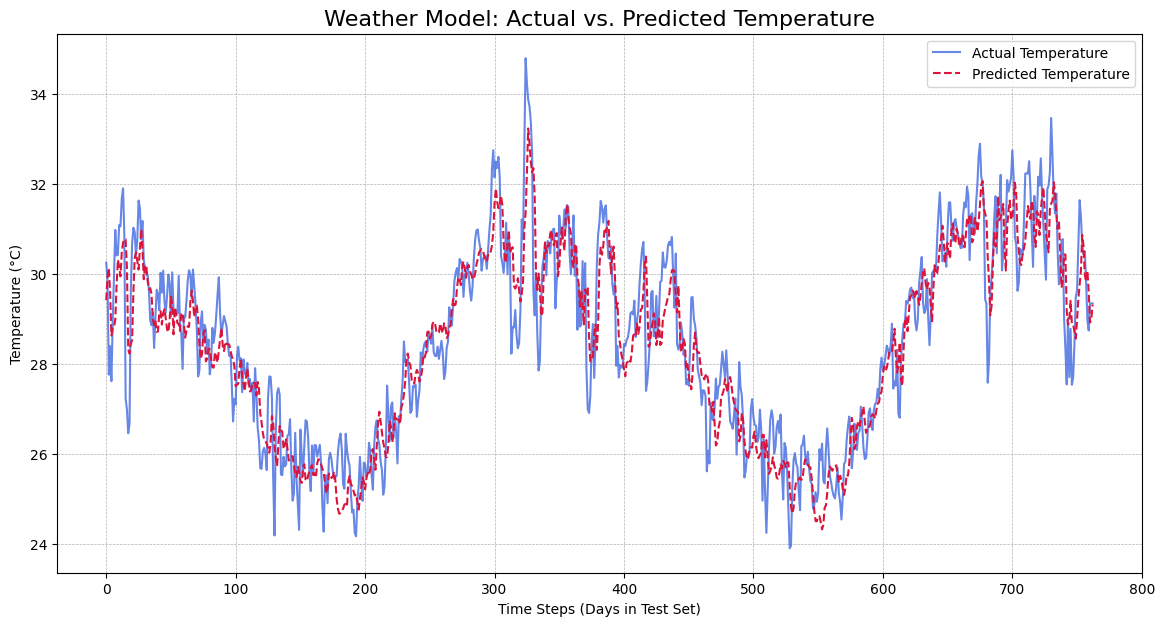


Generated plot 'weather_prediction_vs_actual.png' for visual inspection.


In [ ]:
# ==============================================================================
# --- MODEL 1: WEATHER FORECASTING MODEL WITH EVALUATION ---
# ==============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, Bidirectional, LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# --- 1. Load and Prepare Data ---
print("--- Loading Data for Weather Model ---")
try:
    df = pd.read_csv("/content/drive/Othercomputers/My Laptop (1)/E:/projects/water_crises_management/chennaiWaterCrisis/Datasets/chennai_features_for_lstm.csv", index_col='Date', parse_dates=True)
    df.dropna(inplace=True)
except FileNotFoundError as e:
    print(f"Error: {e}")
    exit()

# --- 2. Feature and Target Selection ---
print("--- Selecting Features and Targets ---")
weather_features = [
    'Rainfall_mm_TOTAL_lag_1', 'Rainfall_mm_TOTAL_lag_3', 'Rainfall_mm_TOTAL_lag_7',
    'temperature_mean_celsius_lag_1', 'temperature_mean_celsius_lag_3', 'temperature_mean_celsius_lag_7',
    'relative_humidity_mean_percent_lag_1', 'relative_humidity_mean_percent_lag_3', 'relative_humidity_mean_percent_lag_7',
    'Rainfall_mm_TOTAL_roll_mean_7', 'temperature_mean_celsius_roll_mean_7', 'relative_humidity_mean_percent_roll_mean_7',
    'Month',
]
weather_targets = [
    'Rainfall_mm_TOTAL',
    'temperature_mean_celsius',
    'relative_humidity_mean_percent'
]
weather_features = [f for f in weather_features if f in df.columns]
data = df[weather_features + weather_targets].copy()
data.dropna(inplace=True)
X = data[weather_features]
y = data[weather_targets]

# --- 3. Data Scaling and Sequencing ---
print("--- Scaling Data and Creating Sequences ---")
scaler_X = MinMaxScaler(feature_range=(0, 1))
X_scaled = scaler_X.fit_transform(X)
scaler_y = MinMaxScaler(feature_range=(0, 1))
y_scaled = scaler_y.fit_transform(y)

def create_sequences(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps), :])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

time_steps = 30
X_seq, y_seq = create_sequences(X_scaled, y_scaled, time_steps)
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, shuffle=False)

# --- 4. Build and Train the LSTM Model ---
print("--- Building and Training Weather LSTM Model ---")
weather_model = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    Bidirectional(LSTM(100, return_sequences=True)), Dropout(0.2),
    Bidirectional(LSTM(50)), Dropout(0.2),
    Dense(50, activation='relu'),
    Dense(y_train.shape[1])
])
weather_model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = weather_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100,
                            batch_size=32, callbacks=[early_stopping], verbose=1)

# ==============================================================================
# --- 5. MODEL EVALUATION (NEW SECTION) ---
# ==============================================================================
print("\n\n--- Evaluating Weather Model Performance on Test Data ---")
# Make predictions on the test set
y_pred_scaled = weather_model.predict(X_test)

# Inverse transform the predictions and actuals to their original scale
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_test_actual = scaler_y.inverse_transform(y_test)

# Calculate and print metrics for each target variable
for i, target_name in enumerate(weather_targets):
    mae = mean_absolute_error(y_test_actual[:, i], y_pred[:, i])
    rmse = np.sqrt(mean_squared_error(y_test_actual[:, i], y_pred[:, i]))
    r2 = r2_score(y_test_actual[:, i], y_pred[:, i])
    print(f"\nMetrics for {target_name}:")
    print(f"  Mean Absolute Error (MAE): {mae:.3f}")
    print(f"  Root Mean Squared Error (RMSE): {rmse:.3f}")
    print(f"  R-squared (R2) Score: {r2:.3f}")

# --- Visualize Predictions vs Actuals for Temperature ---
plt.figure(figsize=(14, 7))
plt.plot(y_test_actual[:, 1], color='royalblue', label='Actual Temperature', alpha=0.8)
plt.plot(y_pred[:, 1], color='crimson', label='Predicted Temperature', linestyle='--')
plt.title('Weather Model: Actual vs. Predicted Temperature', fontsize=16)
plt.xlabel('Time Steps (Days in Test Set)')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.savefig('weather_prediction_vs_actual.png')
plt.show()
print("\nGenerated plot 'weather_prediction_vs_actual.png' for visual inspection.")

In [ ]:
# --- 6. Make and Display a Prediction ---
print("\n--- Making Weather Prediction for 'Tomorrow' ---")
# Prepare the last sequence from the original dataset
last_sequence_X = X_scaled[-time_steps:]
prediction_input = last_sequence_X.reshape(1, time_steps, X.shape[1])

# Make a prediction
predicted_scaled = weather_model.predict(prediction_input)

# Inverse transform the prediction to get the actual values
predicted_weather = scaler_y.inverse_transform(predicted_scaled)

last_date = df.index[-1]
prediction_date = last_date + pd.Timedelta(days=1)

print("\n=====================================================")
print(f"      PREDICTED WEATHER FOR {prediction_date.strftime('%Y-%m-%d')}")
print("=====================================================")
print(f"Predicted Rainfall: {predicted_weather[0][0]:.2f} mm")
print(f"Predicted Temperature: {predicted_weather[0][1]:.2f} °C")
print(f"Predicted Humidity: {predicted_weather[0][2]:.2f} %")
print("=====================================================")


--- Making Weather Prediction for 'Tomorrow' ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step

      PREDICTED WEATHER FOR 2025-08-08
Predicted Rainfall: 15.94 mm
Predicted Temperature: 29.37 °C
Predicted Humidity: 72.62 %


# Resevoir forcasting

In [ ]:
# ==============================================================================
# --- MODEL 2: RESERVOIR FORECASTING MODEL ---
# ==============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, Bidirectional, LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# --- 1. Load and Prepare Data ---
print("--- Loading Data for Reservoir Model ---")
try:
    df = pd.read_csv("/content/drive/Othercomputers/My Laptop (1)/E:/projects/water_crises_management/chennaiWaterCrisis/Datasets/chennai_features_for_lstm.csv", index_col='Date', parse_dates=True)
    df.dropna(inplace=True)
    print("Data loaded successfully.")
except FileNotFoundError as e:
    print(f"Error: {e}")
    exit()

# --- 2. Feature and Target Selection ---
# Predict future reservoir levels based on past levels and past weather
print("--- Selecting Features and Targets ---")
reservoir_features = [
    # Lagged reservoir features
    'Storage_mcft_TOTAL_lag_1', 'Storage_mcft_TOTAL_lag_3', 'Storage_mcft_TOTAL_lag_7',
    'Inflow_cusecs_TOTAL_lag_1', 'Inflow_cusecs_TOTAL_lag_3', 'Inflow_cusecs_TOTAL_lag_7',
    # Rolling means for recent trends
    'Storage_mcft_TOTAL_roll_mean_7', 'Inflow_cusecs_TOTAL_roll_mean_7',
    # CRITICAL: Include recent weather as it directly impacts reservoirs
    'Rainfall_mm_TOTAL_lag_1', 'Rainfall_mm_TOTAL_lag_3',
    'temperature_mean_celsius_lag_1',
    # Time-based features
    'Month',
]
# The targets are the actual reservoir values
reservoir_targets = [
    'Storage_mcft_TOTAL',
    'Inflow_cusecs_TOTAL',
    'Outflow_cusecs_TOTAL'
]

reservoir_features = [f for f in reservoir_features if f in df.columns]
data = df[reservoir_features + reservoir_targets].copy()
data.dropna(inplace=True)

X = data[reservoir_features]
y = data[reservoir_targets]

# --- 3. Data Scaling ---
print("--- Scaling Data ---")
scaler_X_res = MinMaxScaler(feature_range=(0, 1))
X_scaled_res = scaler_X_res.fit_transform(X)

scaler_y_res = MinMaxScaler(feature_range=(0, 1))
y_scaled_res = scaler_y_res.fit_transform(y)

# --- 4. Create Time-Series Sequences ---
def create_sequences_res(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps), :])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

time_steps = 30
X_seq_res, y_seq_res = create_sequences_res(X_scaled_res, y_scaled_res, time_steps)
print(f"Reservoir data transformed into sequences of shape: {X_seq_res.shape}")

X_train_res, X_test_res, y_train_res, y_test_res = train_test_split(X_seq_res, y_seq_res, test_size=0.2, shuffle=False)

# --- 5. Build and Train the LSTM Model ---
print("--- Building and Training Reservoir LSTM Model ---")
reservoir_model = Sequential([
    Input(shape=(X_train_res.shape[1], X_train_res.shape[2])),
    Bidirectional(LSTM(100, return_sequences=True)),
    Dropout(0.2),
    Bidirectional(LSTM(50)),
    Dropout(0.2),
    Dense(50, activation='relu'),
    Dense(y_train_res.shape[1])
])

reservoir_model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history_res = reservoir_model.fit(
    X_train_res, y_train_res,
    validation_data=(X_test_res, y_test_res),
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

# --- 6. Make and Display a Prediction ---
print("\n--- Making Reservoir Prediction for 'Tomorrow' ---")
last_sequence_X_res = X_scaled_res[-time_steps:]
prediction_input_res = last_sequence_X_res.reshape(1, time_steps, X.shape[1])

predicted_scaled_res = reservoir_model.predict(prediction_input_res)
predicted_reservoir = scaler_y_res.inverse_transform(predicted_scaled_res)

last_date = df.index[-1]
prediction_date = last_date + pd.Timedelta(days=1)

print("\n=====================================================")
print(f"    PREDICTED RESERVOIR INFO FOR {prediction_date.strftime('%Y-%m-%d')}")
print("=====================================================")
print(f"Predicted Total Storage: {predicted_reservoir[0][0]:.2f} mcft")
print(f"Predicted Total Inflow: {predicted_reservoir[0][1]:.2f} cusecs")
print(f"Predicted Total Outflow: {predicted_reservoir[0][2]:.2f} cusecs")
print("=====================================================")

--- Loading Data for Reservoir Model ---
Data loaded successfully.
--- Selecting Features and Targets ---
--- Scaling Data ---
Reservoir data transformed into sequences of shape: (3812, 30, 12)
--- Building and Training Reservoir LSTM Model ---
Epoch 1/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - loss: 0.0028 - val_loss: 0.0015
Epoch 2/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 9.3491e-04 - val_loss: 0.0013
Epoch 3/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 3.9226e-04 - val_loss: 0.0021
Epoch 4/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0010 - val_loss: 0.0013
Epoch 5/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 4.2132e-04 - val_loss: 0.0014
Epoch 6/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 5.6994e-04 - val_loss: 0.0013
Epoch 7/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 5.9969e-04 - val_loss: 0.0014
Epoch 8/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 4.8945e-04 - val_loss: 0.0014
Epoch 9/100
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 1



--- Evaluating Reservoir Model Performance on Test Data ---
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

--- Performance Metrics ---

Metrics for Storage_mcft_TOTAL:
  Mean Absolute Error (MAE): 455.992
  Root Mean Squared Error (RMSE): 1290.643
  R-squared (R2) Score: 0.779 (This means the model explains 77.9% of the variance)

Metrics for Inflow_cusecs_TOTAL:
  Mean Absolute Error (MAE): 970.080
  Root Mean Squared Error (RMSE): 2421.783
  R-squared (R2) Score: 0.149 (This means the model explains 14.9% of the variance)

Metrics for Outflow_cusecs_TOTAL:
  Mean Absolute Error (MAE): 652.978
  Root Mean Squared Error (RMSE): 2324.240
  R-squared (R2) Score: 0.082 (This means the model explains 8.2% of the variance)


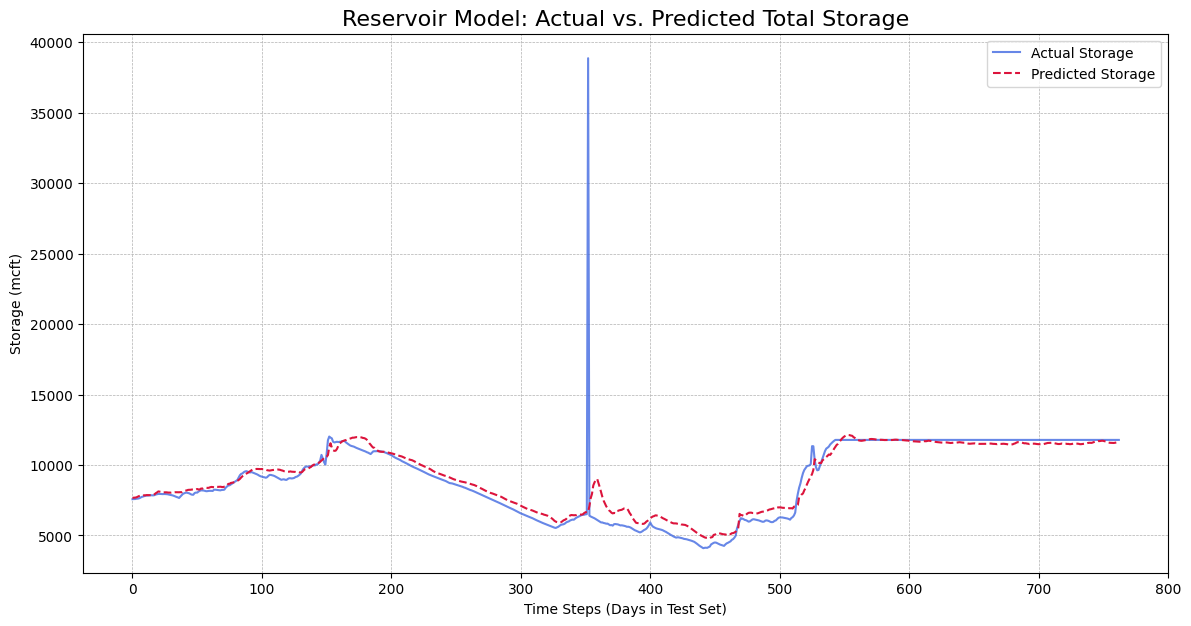

In [ ]:
# ==============================================================================
# --- MODEL EVALUATION BLOCK ---
# ==============================================================================
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
print("\n\n--- Evaluating Reservoir Model Performance on Test Data ---")

# Make predictions on the unseen test set
y_pred_scaled_res = reservoir_model.predict(X_test_res)

# Invert the scaling to get predictions in their original units (e.g., mcft, cusecs)
y_pred_res = scaler_y_res.inverse_transform(y_pred_scaled_res)
y_test_actual_res = scaler_y_res.inverse_transform(y_test_res)

print("\n--- Performance Metrics ---")
# Calculate and print metrics for each of the three reservoir targets
for i, target_name in enumerate(reservoir_targets):
    # MAE tells you the average error in the original units. Lower is better.
    mae = mean_absolute_error(y_test_actual_res[:, i], y_pred_res[:, i])

    # RMSE also measures error, but penalizes large errors more heavily. Lower is better.
    rmse = np.sqrt(mean_squared_error(y_test_actual_res[:, i], y_pred_res[:, i]))

    # R2 Score is like an accuracy percentage for regression. Closer to 1.0 is better.
    r2 = r2_score(y_test_actual_res[:, i], y_pred_res[:, i])

    print(f"\nMetrics for {target_name}:")
    print(f"  Mean Absolute Error (MAE): {mae:.3f}")
    print(f"  Root Mean Squared Error (RMSE): {rmse:.3f}")
    print(f"  R-squared (R2) Score: {r2:.3f} (This means the model explains {r2:.1%} of the variance)")

# --- Visualize Predictions vs Actuals for Total Storage ---
plt.figure(figsize=(14, 7))
plt.plot(y_test_actual_res[:, 0], color='royalblue', label='Actual Storage', alpha=0.8)
plt.plot(y_pred_res[:, 0], color='crimson', label='Predicted Storage', linestyle='--')
plt.title('Reservoir Model: Actual vs. Predicted Total Storage', fontsize=16)
plt.xlabel('Time Steps (Days in Test Set)')
plt.ylabel('Storage (mcft)')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.savefig('reservoir_prediction_vs_actual.png')
plt.show()